<h1><b> Méthode : Filtre Variationnel (4D-Var) </b></h1>

Ce notebook présente l'utilisation en clair d'un filtre variationnel, à l'aide du module ```spotpy``` pour assimiler des données utilisant une méthode variationnelle.

In [3]:
import numpy as np
import spotpy
import sys
sys.path.insert(0, '..\SOURCE')
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

from dataloader import Dataloader 
from pcse.base import ParameterProvider

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from utils import *


This notebook was built with:
python version: 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
PCSE version: 5.5.6


## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.

Dans cet exemple, on va essayer de simuler le champ de notre client


In [5]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**

soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4

sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


In [6]:
cropd = dataloader.getCropData('potato', 'Innovator') # On récupère le type exact de pomme de terre de notre champ
print(cropd)

YAMLCropDataProvider - current active crop 'potato' with variety 'Innovator'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 255, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 187, 'TSUM2': 2100, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.017, 'SLATB': [0.0, 0.0017, 1.0, 0.0024, 2.0, 0.0024], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.49, 40.0, 0.49], 'AMAXTB': [0.0, 33.0, 2.0, 33.0], 'REFCO2L': 400, 'TMPFTB': [0.0, 0.01, 3.0, 0.01, 10.0, 0.75, 15.0, 1.0, 24.0, 1.0, 29.

## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [7]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail() # permet de visualiser les dernières lignes du dataframe avec les valeurs de la simulation

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.210785,22.854223
2022-10-03,1.989233,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.233511,23.990529
2022-10-04,1.993524,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.231742,23.902066
2022-10-05,1.998490,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.230323,23.831142
2022-10-06,2.000000,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.229986,23.814270


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client. On va commencer par tracer deux graphes: l'un pour <b>comprarer les différentes courbes d'humidité et la simulation WOFOST</b>, l'autre avec l'humidité retenu et la prédiction du modèle WOFOST.

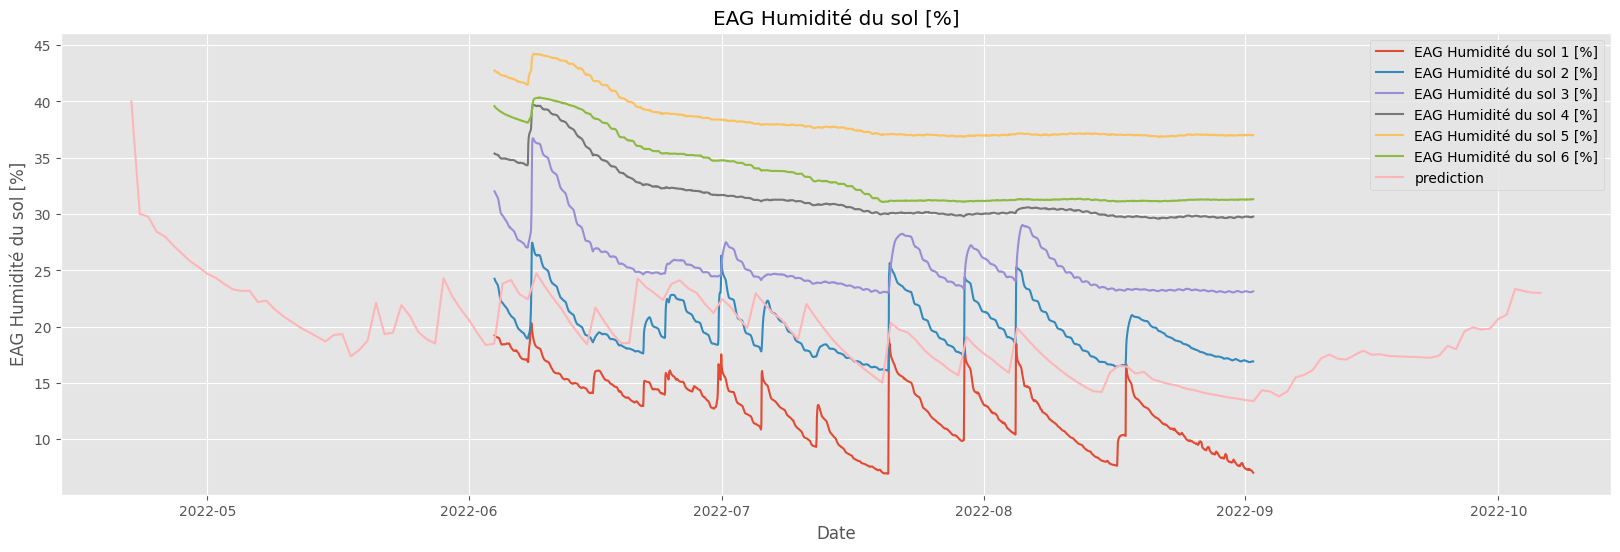

In [8]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

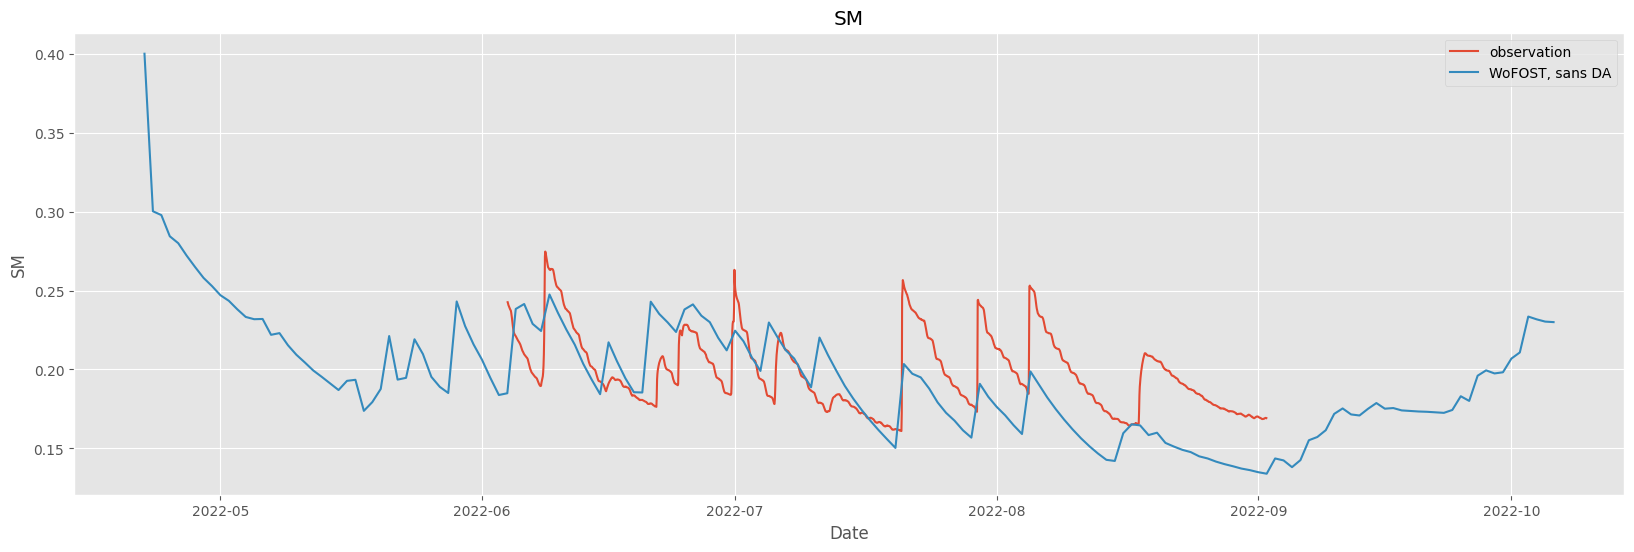

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

On a donc tracé à la fois les observations données par le client, ainsi que les résultats d'une simulation WOFOST sans aucune DA (courbe de base).

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition, avec un pas ```NB_DAYS_DELTA```

In [9]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

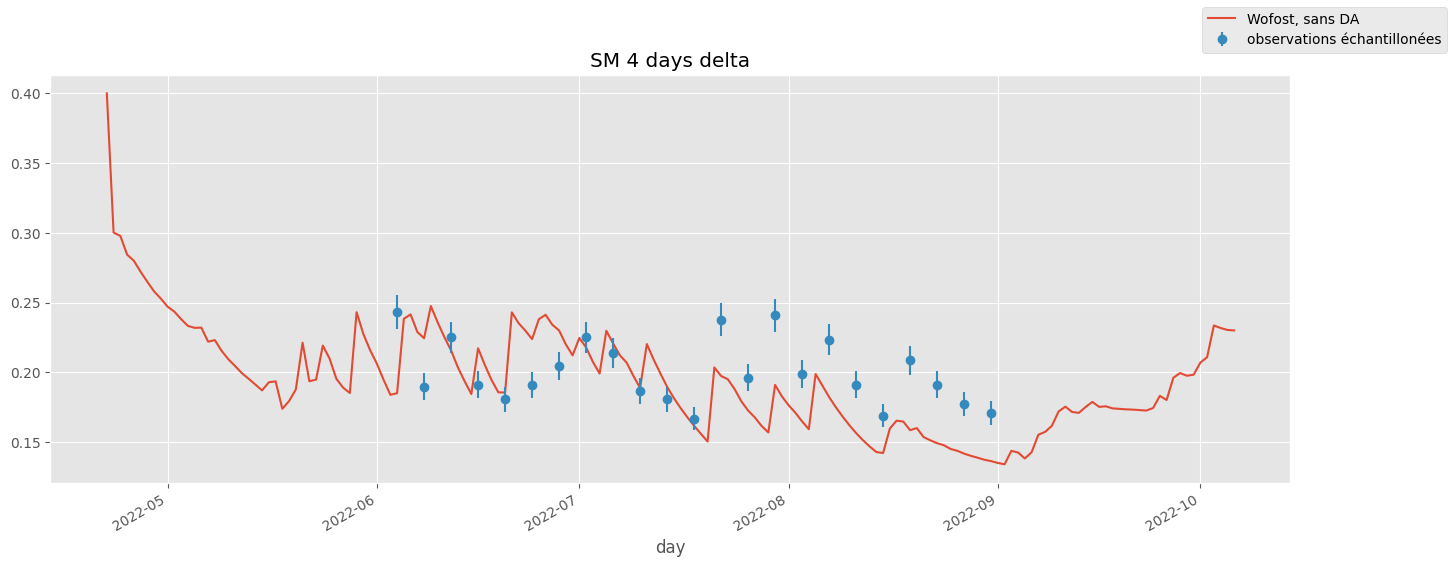

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler sous le format permettant d'entraîner le modèle. On utilise une liste de tuple liant la date aux informations de l'humidité du sol.

In [11]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

# 4 - 4DVAR

Maintenant que l'on a récolté l'ensemble des informations nécessaires pour l'assimilation, utilisons un modèle variationnel pour corriger les estimations.

In [12]:
observations_for_DA

[(Timestamp('2022-06-04 00:00:00'),
  {'SM': (0.24350000000000002, 0.012175000000000002)}),
 (Timestamp('2022-06-08 00:00:00'), {'SM': (0.18969999999999998, 0.009485)}),
 (Timestamp('2022-06-12 00:00:00'), {'SM': (0.225, 0.011250000000000001)}),
 (Timestamp('2022-06-16 00:00:00'), {'SM': (0.1911, 0.009555000000000001)}),
 (Timestamp('2022-06-20 00:00:00'), {'SM': (0.1807, 0.009035)}),
 (Timestamp('2022-06-24 00:00:00'), {'SM': (0.1907, 0.009535000000000002)}),
 (Timestamp('2022-06-28 00:00:00'), {'SM': (0.2045, 0.010225)}),
 (Timestamp('2022-07-02 00:00:00'),
  {'SM': (0.22510000000000002, 0.011255000000000001)}),
 (Timestamp('2022-07-06 00:00:00'), {'SM': (0.2139, 0.010695000000000001)}),
 (Timestamp('2022-07-10 00:00:00'), {'SM': (0.1865, 0.009325)}),
 (Timestamp('2022-07-14 00:00:00'), {'SM': (0.1805, 0.009025)}),
 (Timestamp('2022-07-18 00:00:00'), {'SM': (0.1666, 0.00833)}),
 (Timestamp('2022-07-22 00:00:00'), {'SM': (0.2378, 0.011890000000000001)}),
 (Timestamp('2022-07-26 00:00:

In [13]:
print('== Current parameters ==')
print('TDWI', parameters['TDWI'])
print('WAV', parameters['WAV'])
print('SPAN', parameters['SPAN'])
print('SMFCF', parameters['SMFCF'])

== Current parameters ==
TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3


In [14]:
"""
Ce code est basé sur un code de Tobias Houska, fournis dans Statistical Parameter Estimation Tool (SPOTPY).
Il a été modifié pour s'adapter à notre cas d'étude.
"""

from spotpy.parameter import  Normal


class spot_setup(object):

    # on peut rajouter des paramètres pour compléter
    param_tdwi = Normal(mean=parameters['TDWI'], stddev=10.)
    param_wav = Normal(mean=parameters['WAV'], stddev=1.0)
    param_span = Normal(mean=parameters['SPAN'], stddev=4.)
    param_smfcf = Normal(mean=parameters['SMFCF'], stddev=0.1)
    

    def __init__(self, weather, agrod, observations_for_DA):
        print('[4D VAR] Initialisation...')


        self.weather = weather
        self.agrod = agrod
        self.dates_of_observation = [infos[0] for infos in observations_for_DA]
        self.variables_for_DA = observations_for_DA[0][1].keys()
        self.observations_for_DA = observations_for_DA

        self.paramName_to_id = dict()
        for paramName in self.variables_for_DA:
            self.paramName_to_id[paramName] = len(self.paramName_to_id)

        self.cov_matrix = np.zeros((len(self.dates_of_observation), len(self.variables_for_DA), len(self.variables_for_DA)))
        for i in range(len(observations_for_DA)):
            infos = observations_for_DA[i]
            data = infos[1]

            for paramName, value in data.items():
                paramId = self.paramName_to_id[paramName]
                self.cov_matrix[i, paramId, paramId] = value[1] ** 2

        print("[4D VAR] Init Done")

    def simulation(self, x):
        """
        x : paramètres (tableau)

        Cette fonction doit retourner un tableau contenant les données prédites par le modèle, pour les paramètres données
        """
        print('Simulation...')
        tdwi = x[0]
        wav = x[1]
        span = x[2]
        smfcf = x[3]
        print("[4D VAR - Simulation] Simulating with TDWI: {}  WAV : {} SPAN: {}  SMFCF : {} ".format(tdwi, wav, span, smfcf))       

        p = copy.deepcopy(parameters)
        p.set_override("TDWI", tdwi)
        p.set_override("WAV", wav)
        p.set_override("SPAN", span)
        p.set_override("SMFCF", smfcf)

        member = Wofost72_WLP_FD(p, self.weather, self.agrod)

        try:
            member.run_till_terminate()
            df = pd.DataFrame(member.get_output())
            df['day'] = pd.to_datetime(df['day'])
            df = df.set_index("day")

            corrected_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
            
            for paramName in self.variables_for_DA:

                for i, eval_date in enumerate(self.dates_of_observation):
                    
                    id = self.paramName_to_id[paramName] * len(self.dates_of_observation) + i

                    corrected_list[id] = df[df.index == eval_date][paramName].iloc[0]


            print("=== Corrected_state ===")
            print(corrected_list)

            print("Simulation done")
            return corrected_list
        except:
            print("[4D VAR - Simulation] ERROR - An error occured, abort")


            corrected_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
            
            return corrected_list

    def evaluation(self):        
        """
        Cette fonction doit donner les variables observés
        """

        observed_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
        
        for paramName in self.variables_for_DA:

            for i, eval_date in enumerate(self.dates_of_observation):
                #print(i, eval_date)

                id = self.paramName_to_id[paramName] * len(self.dates_of_observation) + i

                eval_infos = self.observations_for_DA[i][1]
                observed_list[id] = eval_infos[paramName][0]
            

        #print("Evaluation done")
        return observed_list


    def cost_function(self, estimated_list, observed_list, cov_matrix):
        J = 0
        estimated_state = np.reshape(estimated_list, (len(self.variables_for_DA), len(self.dates_of_observation)))
        observed_state = np.reshape(observed_list, (len(self.variables_for_DA), len(self.dates_of_observation)))
        for i in range(estimated_state.shape[1]):
            J += 1/2 * (observed_state[:, i]-estimated_state[:, i]).T @ \
                np.linalg.inv(
                    cov_matrix[i]) @ (observed_state[:, i]-estimated_state[:, i])
        return J

    def objectivefunction(self, simulation, evaluation, params=None):
        """
        Simulation : tableau contenant les données simulées
        Evaluation : tableau contenant les variables observés
        """        
        corrected_J = self.cost_function(simulation, evaluation, self.cov_matrix)

        print('J', corrected_J)
        return corrected_J

In [15]:
spot_setup=spot_setup(weatherd, agrod, observations_for_DA)

[4D VAR] Initialisation...
[4D VAR] Init Done


In [16]:
sampler=spotpy.algorithms.sceua(spot_setup, dbname='test_4dvar', dbformat='csv')

In [17]:
rep=100
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
Simulation...
[4D VAR - Simulation] Simulating with TDWI: 57.37770835092957  WAV : 7.497215585666078 SPAN: 37.45330193311985  SMFCF : 0.19926501787297082 
=== Corrected_state ===
[0.16381136 0.19441203 0.18198952 0.18637866 0.15386926 0.18835796
 0.19479384 0.18306065 0.18583972 0.1534148  0.15067204 0.12412354
 0.16511811 0.13762826 0.15873336 0.13062138 0.14793586 0.12272732
 0.11395502 0.13154199 0.12102809 0.11382294 0.1091335 ]
Simulation done
J 327.7294338947375
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'test_4dvar.csv' created.
Simulation...
[4D VAR - Simulation] Simulating with TDWI: 79.5858992108757  WAV : 9.494113376503021 SPAN: 39.43234603581826  SMFCF : 0.3733726882980288 
=== Corrected_state ===
[0.19960341 0.23660907 0.22508515 0.22984914 0.20149033 0.24067483
 0.2468940

Le code a maintenant fini de tourner. On va pouvoir l'interpréter à l'aide de l'objet ```sampler```.

The figure as been saved as "Parameter_trace.png


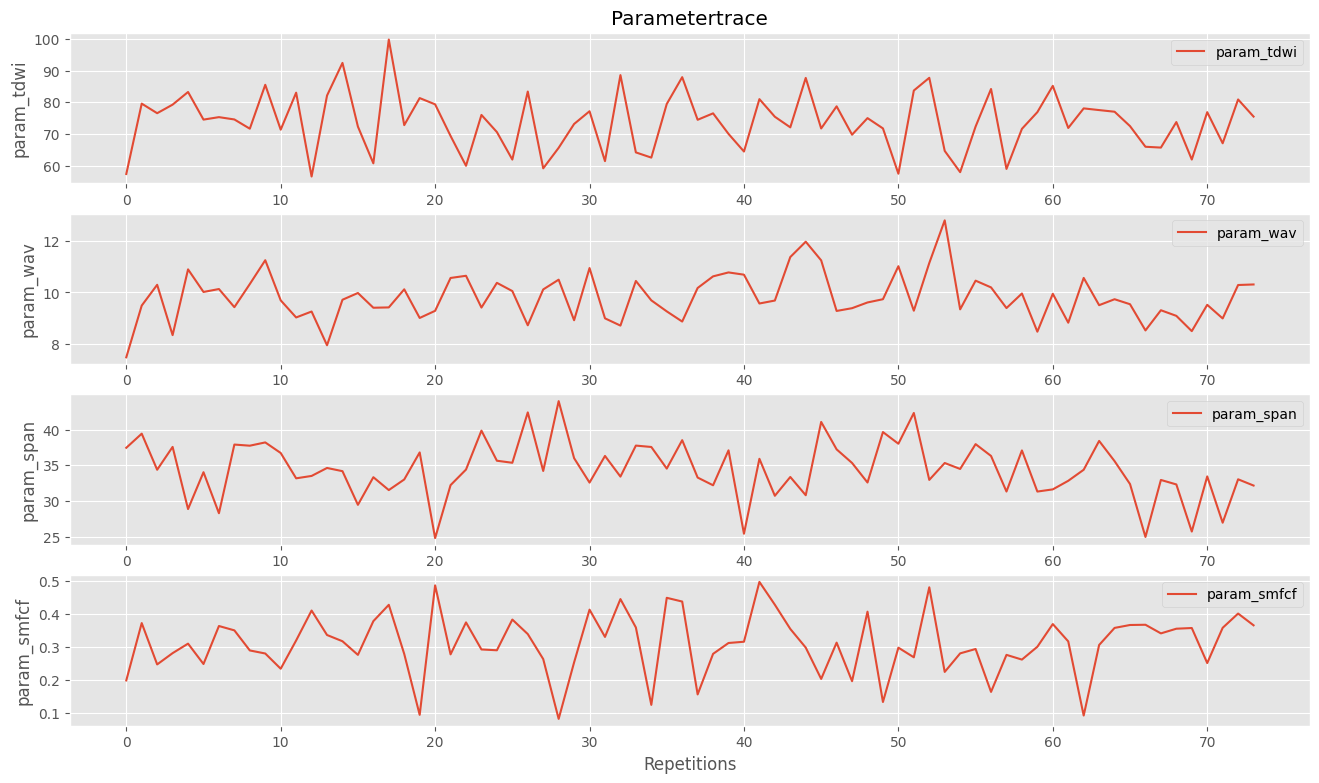

In [18]:
results = sampler.getdata()                          # Load the results
spotpy.analyser.plot_parametertrace(results)         # Show the results

In [19]:
p = copy.deepcopy(parameters)
p.set_override("TDWI", 72.528)
p.set_override("WAV", 10.1205)
p.set_override("SPAN", 29.4625)
p.set_override("SMFCF", 0.33968)

wofost_optimal = Wofost72_WLP_FD(p, weatherd, agrod)
wofost_optimal.run_till_terminate()
df_optimal = pd.DataFrame(wofost_optimal.get_output())
df_optimal['day'] = pd.to_datetime(df_optimal['day'])
df_optimal = df_optimal.set_index("day")

df_optimal

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-04-22,-0.100000,0.072992,58.02240,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.400000,22.600500
2022-04-23,-0.096396,0.072992,58.02240,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.339880,22.474615
2022-04-24,-0.092859,0.072992,58.02240,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.337452,22.450338
2022-04-25,-0.088984,0.072992,58.02240,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.324041,22.316227
2022-04-26,-0.086318,0.072992,58.02240,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.319668,22.272493
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-02,1.983857,0.000000,14520.09352,11068.984353,1843.037042,1608.072125,1414.214751,0.0,50.0,0.239902,24.134235
2022-10-03,1.989233,0.000000,14520.09352,11068.984353,1843.037042,1608.072125,1414.214751,0.0,50.0,0.262628,25.270542
2022-10-04,1.993524,0.000000,14520.09352,11068.984353,1843.037042,1608.072125,1414.214751,0.0,50.0,0.260858,25.182078


On va pouvoir tracer les courbes d'intérêt du modèle. En particulier, il faut que l'on compare avant/après l'assimilation de données, et que l'on s'intéresse au rendement des champs.

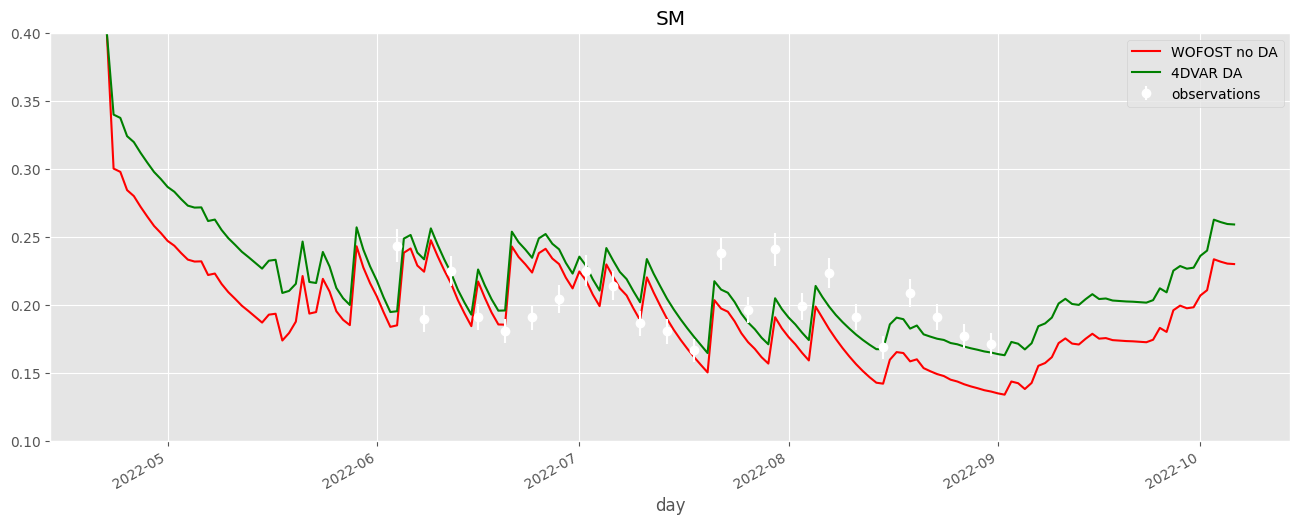

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="WOFOST no DA", alpha=1.0, color='r')
df_optimal["SM"].plot(ax=axes, label="4DVAR DA", alpha=1.0, color='g')
# axes.plot(df_obs['Date/heure'], df_obs['SM'], label="Observations", color='b')
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label="observations", color='white')
axes.set_title("SM")
#axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()
axes.set_ylim([0.10, 0.4])
plt.legend()

On a tracé l'impact de l'assimilation des observations sur les courbes pour le modèle 4DVar: on observe bien une correction importante du modèle et un décalage net.

On peu tracer différentes quantités, dont le <b>TWSO</b> ci-dessous, qui donne accès à l'information du poids total des organes des plantes.

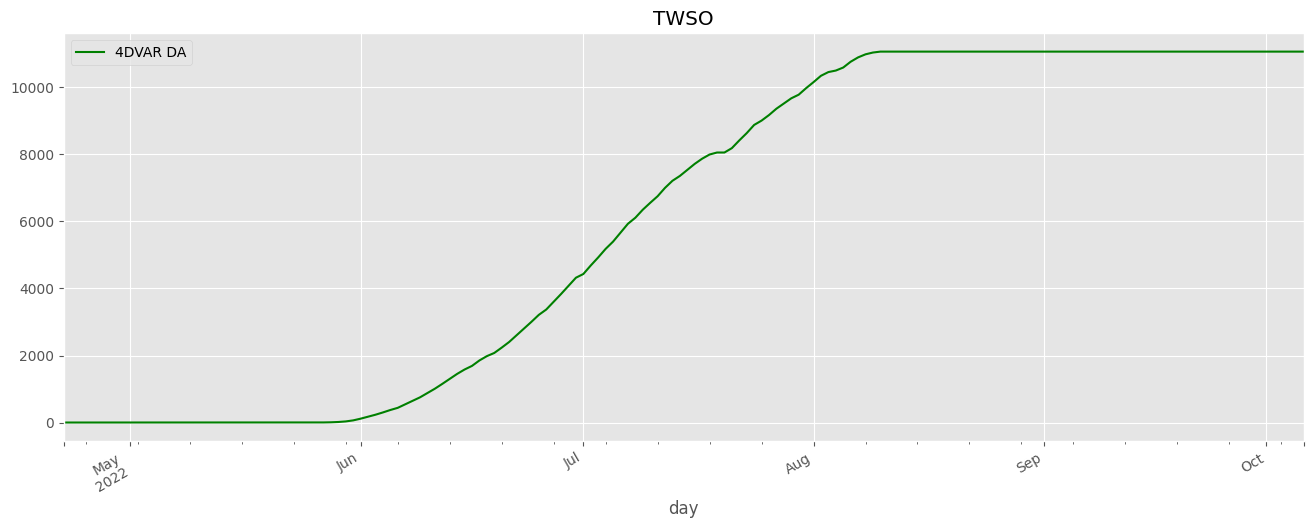

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_optimal["TWSO"].plot(ax=axes, label="4DVAR DA", alpha=1.0, color='g')
axes.set_title("TWSO")
fig.autofmt_xdate()
plt.legend()

On va s'intéresser au métriques d'évaluation. Ci-dessous, un code pour afficher l'évolution du RMSE au fur et à mesure des observations.

RSME en pourcentage pour un pas de 4 avec 4DVar : 0.12461555443173093


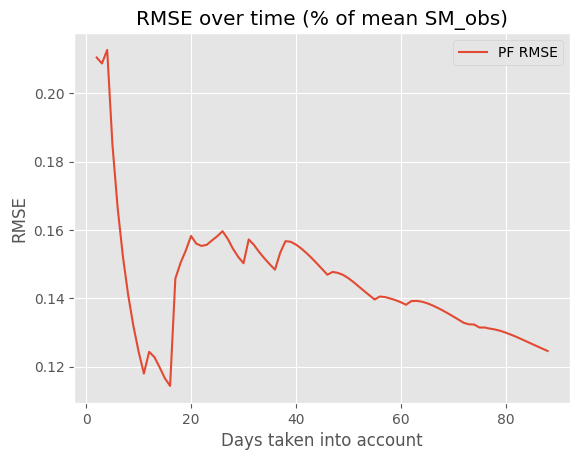

In [25]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
minDay = str(df_obs_undersample['Date/heure'].min())
maxDay = str(df_obs_undersample['Date/heure'].max())

SM_obs = df_obs_undersample['SM'].to_numpy()
SM_DA = df_optimal.loc[(df_optimal.index >= minDay) & (df_optimal.index <= maxDay), 'SM'].to_numpy()
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_DA[1:i])**2)) for i in range(len(SM_DA))}

print("RSME en pourcentage pour un pas de {} avec 4DVar : {}".format(NB_DAYS_DELTA, rsme[len(SM_DA)-1]/np.mean(SM_obs)))
plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="PF RMSE")
plt.title("RMSE over time (% of mean SM_obs)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()

On peut tirer plusieurs conclusion de ce dernier graphique. Le RMSE est initalement très grand: le 4DVar a un écart important initialement avec la réalité. Après plusieurs itérations, il stagn vers un pourcentage d'erreur bien plus raisonnable.
<style>
    table {
        width: 100%;
    }
</style>
| Pas des jours | Erreur RMSE (%) |
|---------------|------- |
|1|12,4|
| 2             | 12,4  |
| 4             | 12,4   |
| 8             | 12,4 |
| 10            | 16,6    |
| <i>témoin</i>        | <i>15</i>    | 
